In [1]:
from galactic import GalacticDataset

Let's use a variant of the Alpaca fine-tuning dataset, with responses generated by GPT-4. We'll take 10,000 examples. As it turns out, there's lots of redundant instructions even in this small subset--Galactic will help us find and pare it down.

In [2]:
ds = GalacticDataset.from_hugging_face(
    "vicgalle/alpaca-gpt4",
    split="train"
).select(range(10000))

We'll embed the "instruction" field, as we want to organize/cluster the data by the sort of queries the user is asking of the model. To save time, we'll use the OpenAI API for embeddings, but if you choose `backend='cpu'`, you can do this right on your computer too!

In [3]:
# have to do this to run async routines (like the openai api) in jupyter
import nest_asyncio
nest_asyncio.apply()

PATH_TO_KEY = "/Users/ben/Desktop/oai_api_key.txt"
ds.set_openai_key(open(PATH_TO_KEY).read().strip())

# lower these to whatever your embeddings rate limits are
ds.set_rate_limits(
    max_requests_per_minute=3000,
    max_tokens_per_minute=500_000
)
ds.get_embeddings(input_field="instruction", backend="openai");

Parameter 'function'=<function get_embeddings.<locals>._embed_batch at 0x138983400> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

INFO: Parallel processing complete.
INFO: Requests left: 7000
INFO: Parallel processing complete.
INFO: Requests left: 4000
INFO: Parallel processing complete.
INFO: Requests left: 1000
INFO: Parallel processing complete.
INFO: Requests left: 0
INFO: Created embeddings on field 'instruction', stored in '__embedding'.


Alright! Now that we have embeddings, we can cluster the dataset. Sometimes, clustering can be more effective if we first reduce the dimensionality of the embeddings. We'll use UMAP to reduce the dimensionality from 1536 to 50.

In [4]:
ds.reduce_embedding_dim(
    n_dims=50,
    method="umap"
); # <- semicolon to suppress output

INFO: Embedding dimension is large, which can slow UMAP down a lot, even for small datasets. You might consider PCA first with e.g. n_dims=50, followed by UMAP.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
INFO: Reduced embeddings to 50 dimensions using umap. New embeddings stored in column '__embedding_umap_50'


Now that we have new embeddings in the `__embedding_umap_50` column, these can be used to cluster the dataset. We'll use the `KMeans` algorithm. Galactic also supports K-Means and HDBSCAN. HDBSCAN is generally recommended for clustering UMAP embeddings, but we'll use BisectingKMeans here for simplicity.

In order to use the right column (rather than the default `__embedding` column), we have to pass the embedding field as an argument.

In [5]:
ds.cluster(
    n_clusters=30,
    method="kmeans",
    embedding_field="__embedding_umap_50"
);

Let's get some basic information about these clusters. Note that we have to pass the embedding field used for clustering, otherwise the `cluster_info` function will use the default `__embedding` column to find nearest neighbors, which will fail because it's 1536 dimensions, while cluster centers are 50.

In [6]:
info = ds.get_cluster_info(embedding_field="__embedding_umap_50", context_fields=["instruction"])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Cluster 22 (216 items)
### Example 1
	- instruction: What are the origins of yoga?
### Example 2
	- instruction: Find two examples of unskilled laborers
### Example 3
	- instruction: Name two muscles used to open the jaw.
Cluster 3 (450 items)
### Example 1
	- instruction: Generate a poem with the given topic. Output a poem of at least 5 lines.
### Example 2
	- instruction: Generate a rap verse about the given topic.
### Example 3
	- instruction: Transform the following paragraph into a poem.
Cluster 14 (313 items)
### Example 1
	- instruction: Develop a creative analogy describing evolution.
### Example 2
	- instruction: How does the phrase “The apple doesn’t fall far from the tree” relate to the concept of genetics?
### Example 3
	- instruction: Describe the visual effect of a single beam of light entering a dark room.
Cluster 23 (473 items)
### Example 1
	- instruction: Connect two events by their causes and effects.
### Example 2
	- instruction: Describe a natural process using onl

This gives us some color on what's going on in each cluster based on its central examples, but it's not easy to read, and it's not exhaustive (a few examples from each cluster may or may not be representative). This also isn't super-scalable to large numbers of clusters or big clusters. Something more scalable: using LLMs to help label clusters. Let's try that!

In [7]:
ds.ai_label_clusters(
    new_column="cluster_label",
    context_fields=["instruction"],
    cluster_field="__cluster",
    # if selection="nearest" it's important to use the same embedding used to create the cluster. 
    # necessary to compute distances to cluster center. doesn't matter if using "random" selection
    embedding_field = "__embedding_umap_50", 
    n_examples=40,
    selection="random",
    prompt=None,  # use the default prompt
);

INFO: Splitting dataset into clusters... (this might take a bit).


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

  0%|          | 0/30 [00:00<?, ?it/s]

INFO: Parallel processing complete.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

We can now see that some clusters have clear themes, while others don't (the default prompt instructs the model to say there's no clear theme if there isn't one).

In [8]:
from collections import Counter
Counter(ds["cluster_label"])

Counter({'No shared topic or theme': 1038,
         'Artificial intelligence and its applications.': 578,
         'Categorization and Classification.': 532,
         'Mathematical problem solving': 519,
         'Language and Sentence Construction.': 506,
         'Text summarization': 479,
         'Environmental Issues': 473,
         'Creative Writing Prompts and Instructions': 450,
         'Marketing and Advertising': 412,
         'Geography and History': 404,
         'Organization and Planning': 388,
         'Figurative language and language analysis': 376,
         'Technology and Information Security': 348,
         'Sorting and Algorithms': 340,
         'Editing and correcting written language': 336,
         'Web and Software Development': 332,
         'Communication and Interactions': 328,
         'Sentence rewriting and modification': 327,
         'No shared topic or theme.': 321,
         'Explanation and Comparison of Concepts': 313,
         'Problem-solving and 

Another thing we could notice from looking at central points in each cluster is that there's a lot of redundancy! We can use semantic deduplication to remove examples that have the same meaning, to leave us with a smaller, diverse dataset. Let's give that a try. We'll target retaining 50% of the data (this will be tuned on a few clusters, so it won't be perfect). We'll use the original `__embedding` field here, because it's normalized and deduplication uses cosine similarity (UMAP does not preserve this). If you want to use `dedup_strategy='nearest'` instead of `'random'` then you have to use the same embedding field used for clustering.

In [9]:
ds.semdedup(
    target_retention=0.5,
    embedding_field="__embedding",
    cluster_field="__cluster",
    num_tuning_clusters=6,
    dedup_strategy="random",
    inplace=True,
);

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

INFO: Tuning threshold on 6 clusters...


Minimum similarity: 0.6523627570654857 Maximum similarity: 1.0000000000000009
Threshold: 0.826, Retention: 0.028
Threshold: 0.913, Retention: 0.761
Threshold: 0.87, Retention: 0.263
Threshold: 0.891, Retention: 0.541
Threshold: 0.88, Retention: 0.407
Threshold: 0.886, Retention: 0.486
Threshold: 0.889, Retention: 0.52
Threshold: 0.887, Retention: 0.498
Minimum similarity: 0.627483047808186 Maximum similarity: 1.000000000000001
Threshold: 0.814, Retention: 0.002
Threshold: 0.907, Retention: 0.432
Threshold: 0.953, Retention: 0.9
Threshold: 0.93, Retention: 0.701
Threshold: 0.919, Retention: 0.558
Threshold: 0.913, Retention: 0.496
Minimum similarity: 0.627483047808186 Maximum similarity: 1.000000000000001
Threshold: 0.814, Retention: 0.002
Threshold: 0.907, Retention: 0.432
Threshold: 0.953, Retention: 0.9
Threshold: 0.93, Retention: 0.701
Threshold: 0.919, Retention: 0.558
Threshold: 0.913, Retention: 0.496
Minimum similarity: 0.6067293670047702 Maximum similarity: 1.0000000000000007
T

INFO: Threshold: 0.9
INFO: Cluster 22 has 108 duplicates (50.0%).

INFO: Cluster 3 has 288 duplicates (64.0%).

INFO: Cluster 14 has 74 duplicates (23.6%).

INFO: Cluster 23 has 264 duplicates (55.8%).

INFO: Cluster 25 has 65 duplicates (41.9%).

INFO: Cluster 8 has 112 duplicates (59.3%).

INFO: Cluster 0 has 239 duplicates (46.1%).

INFO: Cluster 26 has 306 duplicates (55.0%).

INFO: Cluster 19 has 92 duplicates (28.7%).

INFO: Cluster 10 has 253 duplicates (75.3%).

INFO: Cluster 20 has 90 duplicates (22.3%).

INFO: Cluster 21 has 175 duplicates (45.1%).

INFO: Cluster 5 has 358 duplicates (67.3%).

INFO: Cluster 18 has 357 duplicates (61.8%).

INFO: Cluster 17 has 144 duplicates (41.4%).

INFO: Cluster 2 has 111 duplicates (32.6%).

INFO: Cluster 6 has 35 duplicates (53.8%).

INFO: Cluster 24 has 317 duplicates (66.2%).

INFO: Cluster 13 has 45 duplicates (39.8%).

INFO: Cluster 1 has 93 duplicates (70.5%).

INFO: Cluster 11 has 119 duplicates (86.9%).

INFO: Cluster 4 has 184 dup

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

INFO: Removed 5109 / 10000 items flagged as semantic near-duplicates (51.09%).


Next, let's take the data that remains, and make sure that everything we keep actually matches the cluster it was assigned to. That way, we can be confident that the clusters we've grouped data into are meaningful. Then, we may decide to keep clusters related to topics of interest, and discard ones that aren't.

In [10]:
ds = ds.map(
    lambda x: {"instruction_with_cluster": "Instruction: " + x["instruction"] + "\nLabel: " + x["cluster_label"]},
).ai_tagger(
    field="instruction_with_cluster",
    tags={"match": "The instruction matches the label."},
    prompt = None,
    backend="openai",
    allow_not_sure = False,
);

Map:   0%|          | 0/4891 [00:00<?, ? examples/s]

INFO: Tagging with tag match...


Map:   0%|          | 0/4891 [00:00<?, ? examples/s]

INFO: Example prompt for tag match: Tag the provided text with the following tag:
  - match: The instruction matches the label.
Answer True if the tag applies to the text, and False if it does not. 

---

Text: Instruction: Give three tips for staying healthy.
Label: Practical advice and information about various topics

---

Does the tag apply?


  0%|          | 0/4891 [00:00<?, ?it/s]

ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param

In [11]:
print(Counter(ds["__ai_tag__match"]))
ds = ds.filter(
    lambda x: x["__ai_tag__match"] == "True"
)
len(ds)

Counter({'False': 3073, 'True': 1818})


Filter:   0%|          | 0/4891 [00:00<?, ? examples/s]

1818

Now we've deduplicated and made sure that the only remaining datapoints truly match their cluster. Let's look at the data we have left! In order to reasonably visualize high-dimensional data, we have to reduce it to 2 dimensions. We'll use UMAP again, because it's designed to preserve the structure of the data manifold. We'll see how well our clusters are preserved in the 2-D embedding space.

In [13]:
ds.reduce_embedding_dim(
    n_dims=2,
    method="umap",
    new_column="__embedding_umap_2",
    embedding_field="__embedding_umap_50",
);

INFO: Reduced embeddings to 2 dimensions using umap. New embeddings stored in column '__embedding_umap_2'


INFO: Saved plot to umap.png


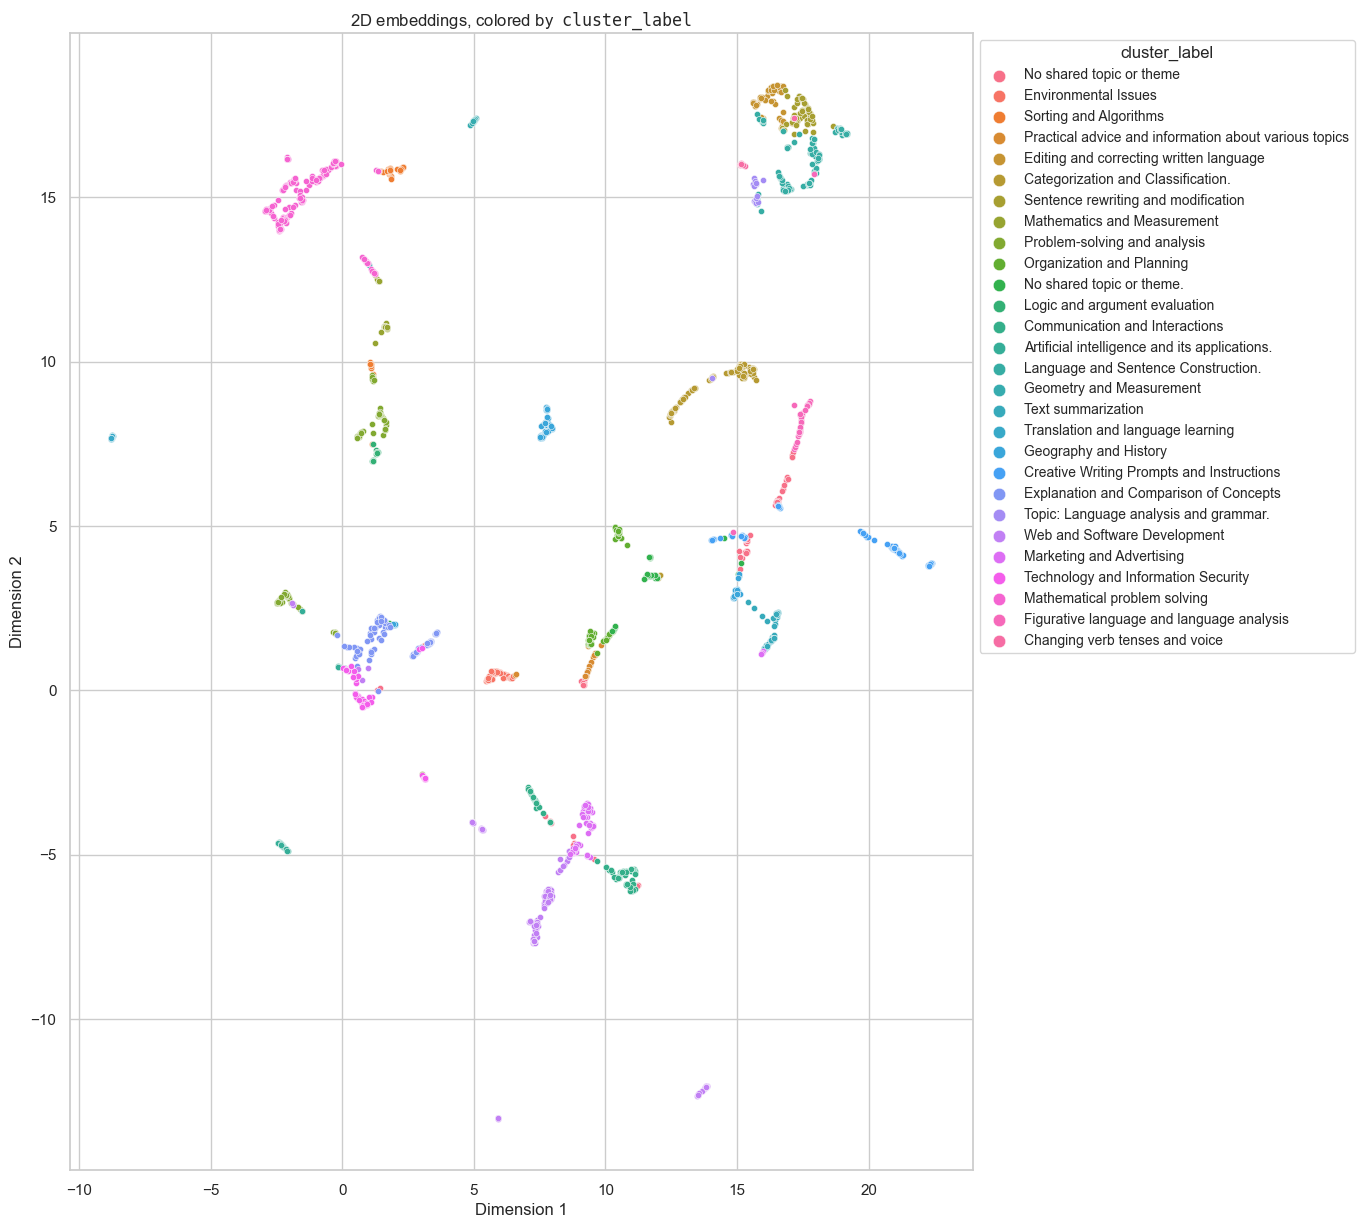

In [15]:
ds.plot_embeddings(
    embedding_field="__embedding_umap_2",
    color_by="cluster_label",
    width=16,
    height=12,
    save_path="umap.png",
    dot_size=20
)

Getting a "good" clustering requires iterating, inspecting your data, and even trying out your downstream task to see how well deduplication is working. UMAP produces very distinct, "isolated" clusters, but when using the `ai_tagger`, I found that some of these clusters are less good at coherently preserving semantic content—that is, fewer points are filtered out for not matching their cluster when the initial dimension reduction is done with PCA instead of UMAP. This is probably because the assumptions of K-means (spherical clusters) doesn't match how UMAP reduces dimensions--it's better suited for HDBSCAN.

Ultimately, you have to experiment, and Galactic provides the tools so you can try all these out with no boilerplate! For now, we'll save this dataset and call it a day.

In [16]:
ds.save("alpaca_cleaned.jsonl", overwrite=True)